Basic code using moving average comparison between 10d and 50d.

Two Optimization Targets => ?

Small Moving Average
Larger Moving Average

Highest value of holdings at end is goal?

Other goals: minimize loss?

In [66]:
## Get BTC/AUD from Kraken
import ccxt
kraken = ccxt.kraken()
ticker = kraken.fetch_ticker('BTC/AUD')
price = ticker['last']

In [93]:
import ccxt
import datetime
import pandas as pd

kraken = ccxt.kraken()
# Load markets
kraken.load_markets()
# Define the trading pair and the timeframe
symbol = 'BTC/AUD' # Remember to change kraken.fetch_ticker if changing
candle_timeframe = '1d'
# Define the start and end dates
iso8601_tail = 'T00:00:00Z'
current_date = datetime.date.today()
timeframe = current_date - datetime.timedelta(days=365*2) # Two Years is 365*2
start_date = str(timeframe)+iso8601_tail
start_ts = kraken.parse8601(start_date)
# The amount of days to fetch.
# 720 is the maximum. Minus 1 as current day not complete.
limit = 719
# Debug Print Statements
print(f"Start Date ISO: {kraken.iso8601(start_ts)}")
# 
ohlcv_data = kraken.fetch_ohlcv(symbol, candle_timeframe, start_ts, limit)
# Convert the data to a Pandas DataFrame and set column names
ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
# Convert the timestamp to a human-readable datetime format
ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')
print(ohlcv_df)
ohlcv_df.to_pickle('dh2.pkl')

Start Date ISO: 2021-04-24T00:00:00.000Z
     timestamp     open     high      low    close     volume
0   2021-05-04  73894.8  73894.8  69285.4  69285.4  15.285541
1   2021-05-05  69029.9  74864.4  69029.9  74324.9  12.059667
2   2021-05-06  74427.4  75319.6  71406.7  72601.1   8.544883
3   2021-05-07  72544.1  75014.2  71527.6  73322.7  12.533144
4   2021-05-08  73772.5  76050.8  73119.9  75195.7  18.172034
..         ...      ...      ...      ...      ...        ...
714 2023-04-18  43948.9  45262.3  43506.8  45038.4  20.093770
715 2023-04-19  45008.5  45041.8  42704.2  42974.2  19.066293
716 2023-04-20  42954.6  43297.5  41615.4  41882.8  22.476483
717 2023-04-21  41884.9  42201.9  40638.8  40742.7  21.284550
718 2023-04-22  40800.5  41831.1  40675.0  41773.0   7.550956

[719 rows x 6 columns]


In [94]:
import ccxt
import datetime
import pandas as pd

import matplotlib.pyplot as plt

kraken = ccxt.kraken()

# Load markets
kraken.load_markets()

dh_df = pd.read_pickle('dh2.pkl')

print(dh_df)
print()

     timestamp     open     high      low    close     volume
0   2021-05-04  73894.8  73894.8  69285.4  69285.4  15.285541
1   2021-05-05  69029.9  74864.4  69029.9  74324.9  12.059667
2   2021-05-06  74427.4  75319.6  71406.7  72601.1   8.544883
3   2021-05-07  72544.1  75014.2  71527.6  73322.7  12.533144
4   2021-05-08  73772.5  76050.8  73119.9  75195.7  18.172034
..         ...      ...      ...      ...      ...        ...
714 2023-04-18  43948.9  45262.3  43506.8  45038.4  20.093770
715 2023-04-19  45008.5  45041.8  42704.2  42974.2  19.066293
716 2023-04-20  42954.6  43297.5  41615.4  41882.8  22.476483
717 2023-04-21  41884.9  42201.9  40638.8  40742.7  21.284550
718 2023-04-22  40800.5  41831.1  40675.0  41773.0   7.550956

[719 rows x 6 columns]



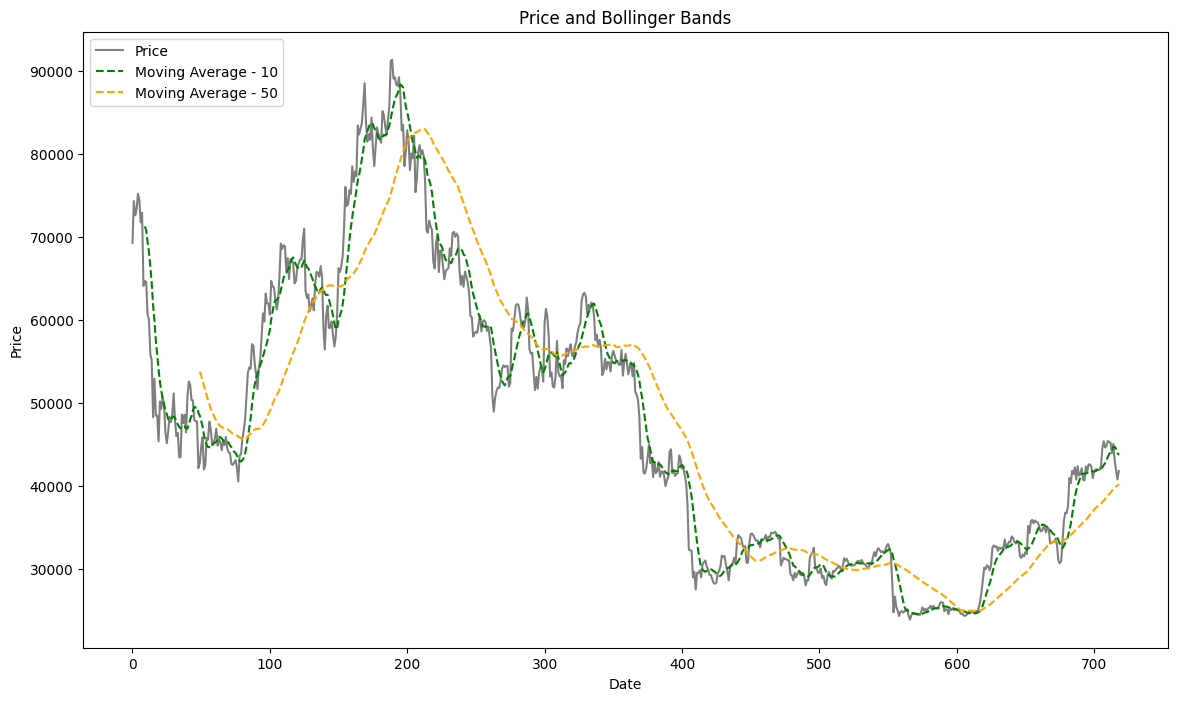

In [98]:
from ta.volatility import BollingerBands

short_window = 10 ### optimization target
medium_window = 50 ### optimization target
#long_window = 100

indicator_bb = BollingerBands(close=dh_df["close"], window=short_window, window_dev=2)
indicator_bb_m = BollingerBands(close=dh_df["close"], window=medium_window, window_dev=2)
#indicator_bb_l = BollingerBands(close=dh_df["close"], window=long_window, window_dev=2)

# Add Bollinger Bands features
dh_df['mavg_s'] = indicator_bb.bollinger_mavg()
dh_df['mavg_m'] = indicator_bb_m.bollinger_mavg()
#dh_df['mavg_l'] = indicator_bb_l.bollinger_mavg()


dh_df['bb_bbh'] = indicator_bb.bollinger_hband()
dh_df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
dh_df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
dh_df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

#print(dh_df)

# Plot the price and Bollinger Bands
plt.figure(figsize=(14, 8))
plt.plot(dh_df['close'], label='Price', alpha=0.5, color='black')
plt.plot(dh_df['mavg_s'], label=f'Moving Average - {short_window}', linestyle='--', color='green')
plt.plot(dh_df['mavg_m'], label=f'Moving Average - {medium_window}', linestyle='--', color='orange')
#plt.plot(dh_df['mavg_l'], label=f'Moving Average - {long_window}', linestyle='--', color='red')

#plt.plot(dh_df['bb_bbh'], label='Bollinger Bands High', linestyle='--', color='blue')
#plt.plot(dh_df['bb_bbl'], label='Bollinger Bands Low', linestyle='--', color='blue')


plt.title('Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.show()

In [96]:
import math
count = 0
toggle = False

fiat_money = 100
btc_money = 0
fee = 0.02 # Each buy or sell event costs 2% of current holdings.

for index, row in dh_df.iterrows():
    if not math.isnan(row['mavg_m']): # Wait until mavg_m is initialized
        if toggle:
            if row['mavg_s'] > row['mavg_m']:
                toggle = False
                count += 1
                fiat_money = ( btc_money * row['close'] ) * (1 - fee)
                btc_money = 0
                print(f"{index} {row['timestamp']}, {fiat_money}")
        else:
            if row['mavg_m'] > row['mavg_s']: # Will be triggered first
                toggle = True
                count += 1
                btc_money = ( fiat_money / row['close'] ) * (1 - fee)
                fiat_money = 0
                print(f"Day:{index},  Date: {row['timestamp']}, {btc_money * row['close']}")



49 2021-06-22 00:00:00, 97.99999999999999
85 2021-07-28 00:00:00, 121.83917718101034
140 2021-09-21 00:00:00, 119.40239363739012
155 2021-10-06 00:00:00, 157.68295179140225
204 2021-11-24 00:00:00, 154.5292927555742
284 2022-02-12 00:00:00, 112.69085413286719
294 2022-02-22 00:00:00, 110.43703705020984
309 2022-03-09 00:00:00, 117.06461491055707
310 2022-03-10 00:00:00, 114.72332261234592
325 2022-03-25 00:00:00, 124.18673301023648
345 2022-04-14 00:00:00, 121.70299835003176
446 2022-07-24 00:00:00, 72.20212001956085
477 2022-08-24 00:00:00, 70.75807761916964
519 2022-10-05 00:00:00, 69.26638727630828
556 2022-11-11 00:00:00, 67.88105953078212
618 2023-01-12 00:00:00, 71.02040106953625
675 2023-03-10 00:00:00, 69.59999304814552
681 2023-03-16 00:00:00, 83.60447063435201


In [97]:
print(f'Amount of Buy/Sell events: {count}')
print(f'BTC (in satoshis): {btc_money}')
print(f'BTC (in fiat): {btc_money * price} ')
print(f'$AUD: {fiat_money}')

Amount of Buy/Sell events: 18
BTC (in satoshis): 0
BTC (in fiat): 0.0 
$AUD: 83.60447063435201
